# FrozenLake


Based on https://github.com/ajmcastro/introduction-intelligent-autonomous-systems/blob/main/OpenAIGymAndRL/OpenAIGym_FrozenLake_Gymnasium.ipynb

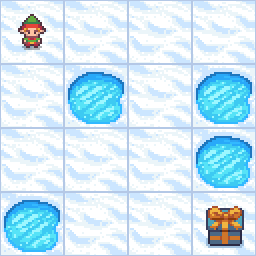

Frozen lake involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. The player may not always move in the intended direction due to the slippery nature of the frozen lake.

The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world e.g. [3,3] for the 4x4 environment.

Holes in the ice are distributed in set locations when using a pre-determined map or in random locations when a random map is generated.

The player makes moves until they reach the goal or fall in a hole.

## Imports

We start by importing the dependencies: Gymnasium (and Wrappers), numpy, random, matplotlib and stable_baselines3. We use Python 3.8.17.

In [1]:
import gymnasium as gym
from gymnasium import RewardWrapper, Wrapper
from stable_baselines3 import PPO, A2C
import numpy as np
import random
import matplotlib.pyplot as plt
import os

## Setting up and exploring the environment

Even though the original problem description has a slippery environment, we are going to start working in a non-slippery environment. In it, if you go right, you only go right; in the original environment, if you intend to go right, you can go right, up or down with 1/3 probability.

To make a deterministic Frozen Lake environment, we make use of the `is_slippery` flag. We'll also use `ansi`as rendering mode, as it is faster to visualize (the other option is `human`, which provides a graphical visualization).

In [2]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="ansi")

Render the environment on the screen.

In [3]:

env.reset()
print(env.render())


SFFF
FHFH
FFFH
HFFG



## Setting up custom environment

The default environment has this reward schedule:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

In an effort to make it more realistic, we decided to apply a RewardWrapper and the reward schedule of the altered environment is:

- Reach goal: +2
- Reach hole: -1
- Reach frozen: -0.01


In [4]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
DIAGONAL_LEFT_UP = 4
DIAGONAL_LEFT_DOWN = 5
DIAGONAL_RIGHT_UP = 6
DIAGONAL_RIGHT_DOWN = 7

class CustomRewardWrapper(RewardWrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)
        # Define your custom rewards for each square
        self.custom_rewards = {
            b'S': 0.0,  # Start
            b'F': -0.01,  # Frozen
            b'H': -1,  # Hole
            b'G': 2    # Goal
        }

    def step(self, action):
        # Take a step in the environment
        step_result = self.env.step(action)
        #print("action " + str(action))
        # Unpack the step result with the additional 'prob' dictionary
        new_state, reward, terminated, truncated, info = step_result
        
        # Customize the reward based on the current state
        current_state = self.env.unwrapped.s
        row = current_state // self.ncol
        col = current_state - row * self.ncol
        tile_type = self.desc[row, col]
        
        # the possible "reward" values ( that come from the movement wrapper ) are:
        # -0.01 ("incorrect" diagonal move), 1 (goal), and 0 (everything else)
        new_reward = self.custom_rewards.get(tile_type, reward)

        
        #print(f"Current state: {tile_type} {new_state}, new reward: {new_reward}")
        
        return new_state, new_reward, terminated, truncated, info
    

class CustomActionWrapper(Wrapper):
    def __init__(self, env):
        super(CustomActionWrapper, self).__init__(env)
        self.action_space = gym.spaces.Discrete(8)

    def step(self, action):
        if action == DIAGONAL_LEFT_UP:
            return self.step_diagonal(LEFT, UP)
        elif action == DIAGONAL_LEFT_DOWN:
            return self.step_diagonal(LEFT, DOWN)
        elif action == DIAGONAL_RIGHT_UP:
            return self.step_diagonal(RIGHT, UP)
        elif action == DIAGONAL_RIGHT_DOWN:
            return self.step_diagonal(RIGHT, DOWN)
        else:
            return self.env.step(action)

    def step_diagonal(self, action_horizontal, action_vertical):
        # Primeiro movimento vertical, depois horizontal
        original_state = self.env.s
        
        vertical_result = self.env.step(action_vertical) # down
        #print("vertical_result " + str(vertical_result))
        new_state_ver = vertical_result[0] 
        
        horizontal_result = self.env.step(action_horizontal) # left
        #print("horizontal_result " + str(horizontal_result))
        new_state = horizontal_result[0] 
        reward = horizontal_result[1]
        terminated = horizontal_result[2]
        truncated = horizontal_result[3]
        info = horizontal_result[4]
        
        # if the agent makes a diagonal move against a wall
        if new_state_ver == new_state or new_state_ver == original_state or new_state == original_state:
            reward -= 0.01
        #self.env.render()
        #print(f"New State: {new_state}, Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}, Info: {info}")

        return new_state, reward, terminated, truncated, info

## Q-Learning

We now proceed to implementing Q-learning and aplying it to our environment. In Q-learning, q-values are updated based on:

$Q(S_{t},A_{t}) \leftarrow Q(S_{t},A_{t}) + \alpha [R_{t+1} + \gamma \max_{a} Q(S_{t+1},a) - Q(S_{t},A_{t})]$

where $\alpha$ is the learning rate (aka step size), and $\gamma$ is the discount factor.

### The Q-table

First, we create a Q-table of shape *state_size* x *action_size*, and initialize its values with zeros.
<br>
**QLearn Class →** *self.qtable = np.zeros((self.state_size, self.action_size))*

### Learning hyperparameters

The Q-learning algorithm has the following hyperparameters:
- the total number of episodes to run
- the maximum number of steps per episode
- the learning rate
- the discount factor
- the range for the exploration parameter epsilon
- the epsilon decay rate

The class QLearn Implements Q-learning and uses it to train the agent, using an $\epsilon$-greedy action selection with decreasing exploration probability. Prints some information as learning takes place.
Keeps a list of the total rewards obtained after each episode.

In [13]:
class QLearn:
    
    def __init__(self, env, total_episodes, max_steps, learning_rate, gamma, epsilon, max_epsilon, min_epsilon, decay_rate, rows):
        self.env = env
        self.action_size = env.action_space.n
        self.state_size = rows**2  
        self.qtable = np.zeros((self.state_size, self.action_size))
        self.rewards = []
        self.total_episodes = total_episodes      # Total episodes
        self.max_steps = max_steps                # Max steps per episode
        self.learning_rate = learning_rate        # Learning rate
        self.gamma = gamma                        # Discounting factor
        self.epsilon = epsilon                    # Exploration rate
        self.max_epsilon = max_epsilon            # Exploration probability at start
        self.min_epsilon = min_epsilon            # Minimum exploration probability
        self.decay_rate = decay_rate              # Exponential decay rate for exploration prob
        self.rows = rows                          # Size of the board
        self.chosen_actions = []                  # List with chosen actions 
        self.episode_rewards = []                 # List with episode rewards


    

    def q_learning(self):
        for episode in range(self.total_episodes):
            # Reset the environment
            state = self.env.reset()[0]
            
            print(f"Episode: {episode + 1}")
            episode_reward = 0
    
            for step in range(self.max_steps):
                # Choose an action (a) in the current world state (s)
                exp_exp_tradeoff = random.uniform(0, 1)
                if exp_exp_tradeoff > self.epsilon:
                    action = np.argmax(self.qtable[state, :])
                else:
                    action = self.env.action_space.sample()
    
                # Store chosen action for this step
                self.chosen_actions.append(action)
    
                # Take the action (a) and observe the outcome state (s') and reward (r)
                new_state, reward, terminated, truncated, info = self.env.step(action)
    
                # Update Q(s,a) = Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                self.qtable[state, action] = self.qtable[state, action] + self.learning_rate * (
                            reward + self.gamma * np.max(self.qtable[new_state, :]) - self.qtable[state, action])
    
                episode_reward += reward
    
                # Update state
                state = new_state
    
                # If done, finish episode
                if terminated or truncated:
                    break
    
            # reduce epsilon (because we need less and less exploration)
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate * episode)
    
            self.rewards.append(episode_reward)
    
            # Print chosen actions for the episode
            print(f"Chosen Actions: {self.chosen_actions}")
            self.chosen_actions = []  # Reset chosen actions for the next episode


    def plot_rewards(self):
        # Create an array of episode numbers for the x-axis
        episodes = np.arange(1, len(self.rewards) + 1)
    
        # Plot the rewards obtained in each episode using a scatter plot
        plt.scatter(episodes, self.rewards, marker='o')
        plt.title('Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.show()
        
    def print_optimal(self):
        # Print the best action in every state
        #LEFT = 0 DOWN = 1 RIGHT = 2 UP = 3
        print(np.argmax(self.qtable,axis=1).reshape(self.rows,self.rows))
        
    def greedy_policy(self):
        state = self.env.reset()[0]

        n_steps = 0
        terminated = False
        while not terminated and n_steps < self.max_steps:
            print(self.env.render())

            # Take the action (index) that has the maximum expected future reward given the state
            action = np.argmax(self.qtable[state, :])

            # Store the chosen action
            self.chosen_actions.append(action)

            # Print the move taken
            print(f"Step {n_steps + 1}: Chose action {action}", end=" - ")

            # Map the action to a human-readable move description
            if action == DIAGONAL_LEFT_UP:
                print("Diagonal Left Up")
            elif action == DIAGONAL_LEFT_DOWN:
                print("Diagonal Left Down")
            elif action == DIAGONAL_RIGHT_UP:
                print("Diagonal Right Up")
            elif action == DIAGONAL_RIGHT_DOWN:
                print("Diagonal Right Down")
            else:
                print("Non-diagonal Move")

            # Make a step to the next state
            new_state, reward, terminated, truncated, info = self.env.step(action)
            state = new_state

            n_steps += 1

        print(self.env.render())
        self.env.close()
        print(n_steps)


    def test_model(self, num_episodes=10):
        for episode in range(num_episodes):
            state = self.env.reset()[0]
            episode_reward = 0
            episode_moves = []

            print(f"Episode {episode + 1} moves:", end=" ")

            for step in range(self.max_steps):
                # Escolher uma ação com base no modelo treinado (política greedy)
                action = np.argmax(self.qtable[state, :])

                # Armazenar a ação escolhida
                self.chosen_actions.append(action)
                episode_moves.append(action)

                # Tomar a ação e observar o novo estado, recompensa, etc.
                new_state, reward, terminated, truncated, info = self.env.step(action)

                # Atualizar a recompensa acumulada
                episode_reward += reward

                # Atualizar o estado
                state = new_state

                # Se terminou, encerrar o episódio
                if terminated or truncated:
                    break

            # Imprimir a sequência de movimentos e a recompensa total do episódio
            moves_str = " -> ".join(map(str, episode_moves))
            print(f"{moves_str} | Reward: {episode_reward}")

       

## Comparing the environments trained with Q_learning 

### 4x4 not slippery:

- **Hyperparameters:**


In [14]:
total_episodes = 10000         # Total episodes
max_steps = 100               # Max steps per episode

learning_rate = 0.01           # Learning rate
gamma = 0.95                  # Discounting factor

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001            # Exponential decay rate for exploration prob

- **Default:**

In [15]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="ansi")
env.reset()
env.reset()
print(env.render())


SFFF
FHFH
FFFH
HFFG



Run the Q-learning alghorithm.

In [16]:
Default = QLearn(env,total_episodes,max_steps,learning_rate,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,4)
Default.q_learning()

Episode: 1
Chosen Actions: [3, 0, 1, 3, 2, 1]
Episode: 2
Chosen Actions: [1, 2]
Episode: 3
Chosen Actions: [0, 0, 0, 1, 2]
Episode: 4
Chosen Actions: [3, 0, 3, 2, 3, 1]
Episode: 5
Chosen Actions: [3, 1, 0, 3, 0, 0, 3, 0, 0, 2, 3, 3, 2, 1, 3, 3, 2, 3, 1]
Episode: 6
Chosen Actions: [0, 2, 0, 0, 1, 2]
Episode: 7
Chosen Actions: [1, 1, 2, 3]
Episode: 8
Chosen Actions: [1, 0, 3, 0, 0, 1, 0, 3, 3, 0, 1, 0, 2]
Episode: 9
Chosen Actions: [1, 1, 1]
Episode: 10
Chosen Actions: [2, 1]
Episode: 11
Chosen Actions: [3, 3, 3, 1, 3, 1, 1, 1]
Episode: 12
Chosen Actions: [0, 3, 2, 1]
Episode: 13
Chosen Actions: [0, 1, 1, 0, 0, 3, 1, 1]
Episode: 14
Chosen Actions: [2, 2, 0, 1]
Episode: 15
Chosen Actions: [2, 2, 1, 3, 2, 0, 0, 1]
Episode: 16
Chosen Actions: [3, 2, 3, 3, 1]
Episode: 17
Chosen Actions: [1, 3, 2, 0, 1, 0, 3, 1, 3, 3, 3, 3, 2, 0, 0, 3, 0, 1, 2]
Episode: 18
Chosen Actions: [3, 0, 3, 3, 3, 2, 0, 2, 0, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3, 0, 0, 1]
Episode: 19
Chosen Actions: [0, 1, 3, 2, 2, 3, 2, 0, 3,

Plot of the cummulative reward obtained throughout the episodes.

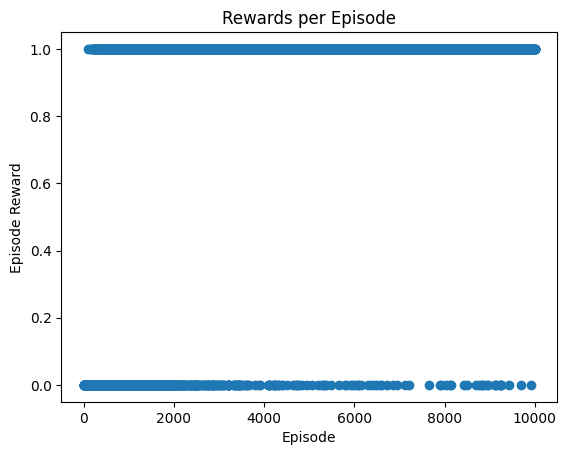

In [17]:
Default.plot_rewards()

Print of the optimal action for each state, according to the obtained Q-table values. All we need to do is to get the action with the maximum value.

In [18]:
Default.print_optimal()

[[1 2 1 0]
 [1 0 1 0]
 [2 2 1 0]
 [0 2 2 0]]


Visualize, state by state, the outcome of following a greedy policy. For that, you just need to choose the best action in each state.

In [19]:
Default.greedy_policy()


SFFF
FHFH
FFFH
HFFG

Step 1: Chose action 1 - Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Step 2: Chose action 1 - Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Step 3: Chose action 2 - Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG

Step 4: Chose action 2 - Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG

Step 5: Chose action 1 - Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Step 6: Chose action 2 - Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG

6


In [20]:
Default.test_model()

Episode 1 moves: 1 -> 1 -> 2 -> 2 -> 1 -> 2 | Reward: 1.0
Episode 2 moves: 1 -> 1 -> 2 -> 2 -> 1 -> 2 | Reward: 1.0
Episode 3 moves: 1 -> 1 -> 2 -> 2 -> 1 -> 2 | Reward: 1.0
Episode 4 moves: 1 -> 1 -> 2 -> 2 -> 1 -> 2 | Reward: 1.0
Episode 5 moves: 1 -> 1 -> 2 -> 2 -> 1 -> 2 | Reward: 1.0
Episode 6 moves: 1 -> 1 -> 2 -> 2 -> 1 -> 2 | Reward: 1.0
Episode 7 moves: 1 -> 1 -> 2 -> 2 -> 1 -> 2 | Reward: 1.0
Episode 8 moves: 1 -> 1 -> 2 -> 2 -> 1 -> 2 | Reward: 1.0
Episode 9 moves: 1 -> 1 -> 2 -> 2 -> 1 -> 2 | Reward: 1.0
Episode 10 moves: 1 -> 1 -> 2 -> 2 -> 1 -> 2 | Reward: 1.0


- Slippery

In [51]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="ansi")
env.reset()
env.reset()
print(env.render())


SFFF
FHFH
FFFH
HFFG



Run the Q-learning alghorithm slippery.

In [52]:
Default = QLearn(env,total_episodes,max_steps,learning_rate,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,4)
Default.q_learning()

Default.greedy_policy()

In [54]:
Default.test_model()

Episode 1 moves: 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 1 -> 0 -> 1 -> 1 -> 2 -> 2 -> 2 -> 2 -> 1 -> 3 -> 3 -> 3 -> 3 -> 1 -> 2 -> 1 -> 2 -> 2 -> 1 -> 2 -> 1 -> 3 -> 3 -> 3 -> 1 -> 2 -> 1 -> 2 -> 1 -> 2 -> 1 | Reward: 1.0
Episode 2 moves: 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 3 -> 3 -> 0 -> 0 -> 0 -> 3 -> 1 -> 2 -> 2 -> 1 -> 2 -> 1 | Reward: 1.0
Episode 3 moves: 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 3 -> 3 -> 0 -> 0 -> 0 -> 3 -> 1 -> 3 -> 3 -> 1 -> 3 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 3 -> 1 -> 2 -> 1 | Reward: 1.0
Episode 4 moves: 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 0 -> 3 -> 1 -> 2 -> 1 -> 3 -> 0 -> 3 -> 3 -> 0 -> 0 -> 0 -> 3 -> 3 -> 1 -> 0 -> 1 -> 1 -> 2 -> 2 -> 1 | Reward: 1.0
Episode 5 mov

- Slippery mode is very unpredictable.

- **Custom:**

In [21]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="ansi")
env = CustomRewardWrapper(env)
env = CustomActionWrapper(env)
env.reset()
print(env.render())


SFFF
FHFH
FFFH
HFFG



Run the Q-learning alghorithm.

In [22]:
Custom = QLearn(env,total_episodes,max_steps,learning_rate,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,4)
Custom.q_learning()

Episode: 1
Chosen Actions: [6, 1]
Episode: 2
Chosen Actions: [1, 0, 1, 4, 2]
Episode: 3
Chosen Actions: [3, 5, 3, 6, 3, 2, 7]
Episode: 4
Chosen Actions: [1, 5, 4, 4, 3, 0, 1, 0, 3, 4, 3, 2, 1]
Episode: 5
Chosen Actions: [5, 5, 2, 1, 4, 3, 2]
Episode: 6
Chosen Actions: [4, 7]
Episode: 7
Chosen Actions: [6, 7]
Episode: 8
Chosen Actions: [0, 3, 7]
Episode: 9
Chosen Actions: [0, 1, 5, 2, 1, 7, 3, 6]
Episode: 10
Chosen Actions: [2, 2, 0, 2, 7]
Episode: 11
Chosen Actions: [4, 5, 6, 2, 5]
Episode: 12
Chosen Actions: [0, 3, 5, 7, 7, 5, 7, 2]
Episode: 13
Chosen Actions: [2, 6, 1, 5, 6]
Episode: 14
Chosen Actions: [7]
Episode: 15
Chosen Actions: [2, 3, 5]
Episode: 16
Chosen Actions: [7]
Episode: 17
Chosen Actions: [3, 7]
Episode: 18
Chosen Actions: [6, 2, 1, 0]
Episode: 19
Chosen Actions: [0, 7]
Episode: 20
Chosen Actions: [1, 6, 5]
Episode: 21
Chosen Actions: [3, 7]
Episode: 22
Chosen Actions: [3, 4, 2, 6, 2, 4, 5]
Episode: 23
Chosen Actions: [2, 6, 7]
Episode: 24
Chosen Actions: [3, 3, 4, 1, 1

/home/pinthoz/.pyenv/versions/TP2/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s` for environment variables or `env.get_wrapper_attr('s')` that will search the reminding wrappers.
  logger.warn(
/home/pinthoz/.pyenv/versions/TP2/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.ncol to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.ncol` for environment variables or `env.get_wrapper_attr('ncol')` that will search the reminding wrappers.
  logger.warn(
/home/pinthoz/.pyenv/versions/TP2/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.desc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desc` for environment variables or `env.get_w

Chosen Actions: [0, 0, 4, 3, 0, 4, 3, 7]
Episode: 109
Chosen Actions: [0, 3, 0, 7]
Episode: 110
Chosen Actions: [7]
Episode: 111
Chosen Actions: [4, 7]
Episode: 112
Chosen Actions: [5, 6, 2, 2, 6, 2, 1]
Episode: 113
Chosen Actions: [0, 0, 6, 3, 6, 7]
Episode: 114
Chosen Actions: [7]
Episode: 115
Chosen Actions: [5, 3, 1, 3, 1, 1, 3, 3, 7]
Episode: 116
Chosen Actions: [0, 5, 3, 5, 1, 5]
Episode: 117
Chosen Actions: [2, 0, 6, 3, 0, 1, 7, 5]
Episode: 118
Chosen Actions: [4, 7]
Episode: 119
Chosen Actions: [0, 4, 5, 3, 1, 1, 4, 7, 3]
Episode: 120
Chosen Actions: [6, 4, 6, 3, 4, 6, 3, 1]
Episode: 121
Chosen Actions: [5, 4, 3, 4, 0, 1, 3, 2, 7]
Episode: 122
Chosen Actions: [2, 3, 0, 7]
Episode: 123
Chosen Actions: [1, 0, 1, 4, 6, 4, 7]
Episode: 124
Chosen Actions: [3, 0, 0, 4, 4, 5, 0, 3, 0, 1, 1, 1]
Episode: 125
Chosen Actions: [4, 0, 0, 3, 0, 3, 0, 6, 0, 2, 0, 5, 5, 6]
Episode: 126
Chosen Actions: [1, 0, 1, 1]
Episode: 127
Chosen Actions: [5, 7, 7, 3, 2]
Episode: 128
Chosen Actions: [5, 3,

Plot of the cummulative reward obtained throughout the episodes.

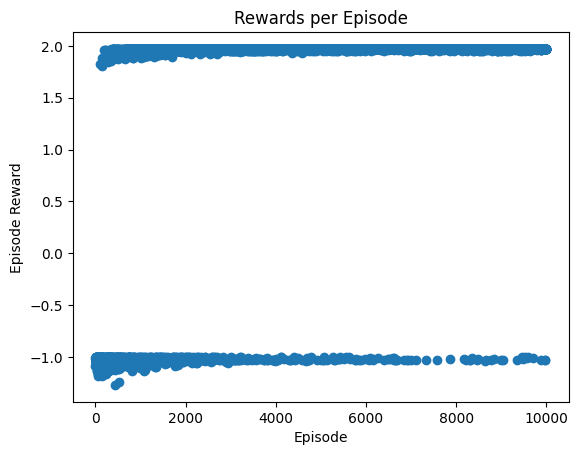

In [57]:
Custom.plot_rewards()

Print of the optimal action for each state, according to the obtained Q-table values. All we need to do is to get the action with the maximum value.

In [58]:
Custom.print_optimal()

[[1 2 1 0]
 [7 0 1 0]
 [2 2 7 0]
 [0 2 2 0]]


Visualize, state by state, the outcome of following a greedy policy. For that, you just need to choose the best action in each state.

In [59]:
Custom.greedy_policy()


SFFF
FHFH
FFFH
HFFG

Step 1: Chose action 1 - Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Step 2: Chose action 7 - Diagonal Right Down
  (Right)
SFFF
FHFH
FFFH
HFFG

Step 3: Chose action 2 - Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG

Step 4: Chose action 7 - Diagonal Right Down
  (Right)
SFFF
FHFH
FFFH
HFFG

4


In [50]:
Custom.test_model()

Episode 1 moves: 1 -> 7 -> 2 -> 7 | Reward: 1.97
Episode 2 moves: 1 -> 7 -> 2 -> 7 | Reward: 1.97
Episode 3 moves: 1 -> 7 -> 2 -> 7 | Reward: 1.97
Episode 4 moves: 1 -> 7 -> 2 -> 7 | Reward: 1.97
Episode 5 moves: 1 -> 7 -> 2 -> 7 | Reward: 1.97
Episode 6 moves: 1 -> 7 -> 2 -> 7 | Reward: 1.97
Episode 7 moves: 1 -> 7 -> 2 -> 7 | Reward: 1.97
Episode 8 moves: 1 -> 7 -> 2 -> 7 | Reward: 1.97
Episode 9 moves: 1 -> 7 -> 2 -> 7 | Reward: 1.97
Episode 10 moves: 1 -> 7 -> 2 -> 7 | Reward: 1.97


- With our modifications he reaches the goal in 4 steps

- **Custom Slippery** 

In [60]:
total_episodes = 100000         
max_steps = 100  
learning_rate = 0.01  
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="ansi")
env = CustomRewardWrapper(env)
env = CustomActionWrapper(env)
env.reset()
print(env.render())


SFFF
FHFH
FFFH
HFFG



In [61]:
Custom = QLearn(env,total_episodes,max_steps,learning_rate,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,4)
Custom.q_learning()

In [62]:
Custom.print_optimal()

[[0 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


In [63]:
Custom.greedy_policy()


SFFF
FHFH
FFFH
HFFG

Step 1: Chose action 0 - Non-diagonal Move
  (Left)
SFFF
FHFH
FFFH
HFFG

Step 2: Chose action 0 - Non-diagonal Move
  (Left)
SFFF
FHFH
FFFH
HFFG

Step 3: Chose action 0 - Non-diagonal Move
  (Left)
SFFF
FHFH
FFFH
HFFG

Step 4: Chose action 0 - Non-diagonal Move
  (Left)
SFFF
FHFH
FFFH
HFFG

Step 5: Chose action 0 - Non-diagonal Move
  (Left)
SFFF
FHFH
FFFH
HFFG

Step 6: Chose action 0 - Non-diagonal Move
  (Left)
SFFF
FHFH
FFFH
HFFG

Step 7: Chose action 0 - Non-diagonal Move
  (Left)
SFFF
FHFH
FFFH
HFFG

Step 8: Chose action 0 - Non-diagonal Move
  (Left)
SFFF
FHFH
FFFH
HFFG

Step 9: Chose action 0 - Non-diagonal Move
  (Left)
SFFF
FHFH
FFFH
HFFG

Step 10: Chose action 0 - Non-diagonal Move
  (Left)
SFFF
FHFH
FFFH
HFFG

Step 11: Chose action 0 - Non-diagonal Move
  (Left)
SFFF
FHFH
FFFH
HFFG

Step 12: Chose action 0 - Non-diagonal Move
  (Left)
SFFF
FHFH
FFFH
HFFG

Step 13: Chose action 3 - Non-diagonal Move
  (Up)
SFFF
FHFH
FFFH
HFFG

Step 14: Chose action 0 - N

- Every time we run the *greedy_policy()*, the solution found is always different. We lowered the learning rate and increased the number of steps in hopes of getting a more stable model, but that was not possible. This might be happening because of the stochastic nature of the environment.

In [64]:
Custom.test_model()

Episode 1 moves: 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 3 -> 3 -> 1 -> 2 -> 1 | Reward: 1.83
Episode 2 moves: 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 1 -> 2 -> 1 -> 3 -> 3 -> 1 -> 0 -> 1 -> 0 -> 1 -> 1 | Reward: 1.78
Episode 3 moves: 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 3 -> 3 -> 1 -> 3 -> 3 -> 0 -> 0 -> 3 -> 1 -> 3 -> 1 -> 0 -> 1 -> 1 -> 2 -> 1 -> 0 -> 1 -> 2 -> 1 -> 2 -> 1 -> 3 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 3 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 3 -> 1 -> 2 -> 2 -> 1 -> 2 -> 1 -> 0 -> 1 -> 2 -> 1 -> 1 | Reward: 1.4699999999999998
Episode 4 moves: 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 3 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 3 -> 1 -> 2 -> 1 -> 1 -> 2 -> 1 | Reward: 

- Very unpredictable

# Stable baselines3


## <b> PPO </b> for 4x4

- Default

Code to train Default Env with PPO

In [89]:
models_dir = "models/PPO_default"
logdir = "logs"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

env = gym.make('FrozenLake-v1',is_slippery=False)
env.reset()

model = PPO('MlpPolicy', env, verbose=0, tensorboard_log=logdir)

TIMESTEPS = 10000
iters = 0
for i in range(100):
    iters+=1
    print(f"iteration {iters}")
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO_default",progress_bar=True)
    model.save(f"{models_dir}/{TIMESTEPS*i}")

Output()

iteration 1


Output()

iteration 2


Output()

iteration 3


Output()

iteration 4


Output()

iteration 5


Output()

iteration 6


Output()

iteration 7


Output()

iteration 8


Output()

iteration 9


Output()

iteration 10


Output()

iteration 11


Output()

iteration 12


Output()

iteration 13


Output()

iteration 14


Output()

iteration 15


Output()

iteration 16


Output()

iteration 17


Output()

iteration 18


Output()

iteration 19


Output()

iteration 20


Output()

iteration 21


Output()

iteration 22


Output()

iteration 23


Output()

iteration 24


Output()

iteration 25


Output()

iteration 26


Output()

iteration 27


Output()

iteration 28


Output()

iteration 29


Output()

iteration 30


Output()

iteration 31


Output()

iteration 32


Output()

iteration 33


Output()

iteration 34


Output()

iteration 35


Output()

iteration 36


Output()

iteration 37


Output()

iteration 38


Output()

iteration 39


Output()

iteration 40


Output()

iteration 41


Output()

iteration 42


Output()

iteration 43


Output()

iteration 44


Output()

iteration 45


Output()

iteration 46


Output()

iteration 47


Output()

iteration 48


Output()

iteration 49


Output()

iteration 50


Output()

iteration 51


Output()

iteration 52


Output()

iteration 53


Output()

iteration 54


Output()

iteration 55


Output()

iteration 56


Output()

iteration 57


Output()

iteration 58


Output()

iteration 59


Output()

iteration 60


Output()

iteration 61


Output()

iteration 62


Output()

iteration 63


Output()

iteration 64


Output()

iteration 65


Output()

iteration 66


Output()

iteration 67


Output()

iteration 68


Output()

iteration 69


Output()

iteration 70


Output()

iteration 71


Output()

iteration 72


Output()

iteration 73


Output()

iteration 74


Output()

iteration 75


Output()

iteration 76


Output()

iteration 77


Output()

iteration 78


Output()

iteration 79


Output()

iteration 80


Output()

iteration 81


Output()

iteration 82


Output()

iteration 83


Output()

iteration 84


Output()

iteration 85


Output()

iteration 86


Output()

iteration 87


Output()

iteration 88


Output()

iteration 89


Output()

iteration 90


Output()

iteration 91


Output()

iteration 92


Output()

iteration 93


Output()

iteration 94


Output()

iteration 95


Output()

iteration 96


Output()

iteration 97


Output()

iteration 98


Output()

iteration 99


Output()

iteration 100


Code to test Default Env with PPO

In [91]:
models_dir = "models/PPO_default"

env = gym.make('FrozenLake-v1', is_slippery=False, render_mode='ansi')
env.reset()
model_path = f"{models_dir}/990000"
model = PPO.load(model_path, env=env)

episodes = 5

for ep in range(episodes):
    obs, info = env.reset()
    done = False
    actions_taken = []  # List to store actions taken during the episode

    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, truncated, info = env.step(int(action))
        actions_taken.append(action)  # Store the action taken
        env.render()
                # Map the action to a human-readable move description
        if action == DIAGONAL_LEFT_UP:
            print("Diagonal Left Up")
        elif action == DIAGONAL_LEFT_DOWN:
            print("Diagonal Left Down")
        elif action == DIAGONAL_RIGHT_UP:
            print("Diagonal Right Up")
        elif action == DIAGONAL_RIGHT_DOWN:
            print("Diagonal Right Down")
        else:
            print("Non-diagonal Move")
        print(env.render())

    # Display the actions taken after the episode is complete
    actions_taken_int = [int(action.item()) for action in actions_taken]
    print(f"\nActions taken in episode {ep + 1}: {actions_taken_int}\n")

Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG


Actions taken in episode 1: [2, 2, 1, 1, 1, 2]

Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG


Actions taken in episode 2: [2, 2, 1, 1, 1, 2]

Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Down)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move
  (Right)
SFFF
FHFH
FFFH
HFFG


Actions taken in episode 3: 

- **Custom**

Code to train with PPO with custom Env

In [ ]:
models_dir = "models/PPO_1"
logdir = "logs"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

env = gym.make('FrozenLake-v1',is_slippery=False)
env = CustomActionWrapper(CustomRewardWrapper(env))
env.reset()

model = PPO('MlpPolicy', env, verbose=0, tensorboard_log=logdir)

TIMESTEPS = 10000
iters = 0
for i in range(100):
    iters+=1
    print(f"iteration {iters}")
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO",progress_bar=True)
    model.save(f"{models_dir}/{TIMESTEPS*i}")

- Code to test PPO with 1M of timesteps

In [84]:
models_dir = "models/PPO"


env = gym.make('FrozenLake-v1', is_slippery=False, render_mode='ansi')
env = CustomRewardWrapper(env)
env = CustomActionWrapper(env)
env.reset()
model_path = f"{models_dir}/990000"
model = PPO.load(model_path, env=env)

episodes = 5

for ep in range(episodes):
    obs, info = env.reset()
    done = False
    actions_taken = []  # List to store actions taken during the episode

    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, truncated, info = env.step(int(action))
        actions_taken.append(action)  # Store the action taken
        env.render()
                # Map the action to a human-readable move description
        if action == DIAGONAL_LEFT_UP:
            print("Diagonal Left Up")
        elif action == DIAGONAL_LEFT_DOWN:
            print("Diagonal Left Down")
        elif action == DIAGONAL_RIGHT_UP:
            print("Diagonal Right Up")
        elif action == DIAGONAL_RIGHT_DOWN:
            print("Diagonal Right Down")
        else:
            print("Non-diagonal Move")
        print(env.render())

    # Display the actions taken after the episode is complete
    actions_taken_int = [int(action.item()) for action in actions_taken]
    print(f"\nActions taken in episode {ep + 1}: {actions_taken_int}\n")

Diagonal Right Down

(Right)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move

(Right)
SFFF
FHFH
FFFH
HFFG

Diagonal Right Down

(Right)
SFFF
FHFH
FFFH
HFFG

Actions taken in episode 1: [1, 7, 2, 7]

Non-diagonal Move

(Down)
SFFF
FHFH
FFFH
HFFG

Diagonal Right Down

(Right)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move

(Right)
SFFF
FHFH
FFFH
HFFG

Diagonal Right Down

(Right)
SFFF
FHFH
FFFH
HFFG

Actions taken in episode 2: [1, 7, 2, 7]

Non-diagonal Move

(Down)
SFFF
FHFH
FFFH
HFFG

Diagonal Right Down

(Right)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move

(Right)
SFFF
FHFH
FFFH
HFFG

Diagonal Right Down

(Right)
SFFF
FHFH
FFFH
HFFG

Actions taken in episode 3: [1, 7, 2, 7]

Non-diagonal Move

(Down)
SFFF
FHFH
FFFH
HFFG

Diagonal Right Down

(Right)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move

(Right)
SFFF
FHFH
FFFH
HFFG

Diagonal Right Down

(Right)
SFFF
FHFH
FFFH
HFFG

Actions taken in episode 4: [1, 7, 2, 7]

Non-diagonal Move

(Down)
SFFF
FHFH
FFFH
HFFG

Diagonal Right Down

(Right)
SFFF
FHFH
FFFH
HFFG

Non-diagonal Move

(Right)
SFFF
FHFH
FFFH
HFFG

Diagonal Right Down

(Right)
SFFF
FHFH
FFFH
HFFG

Actions taken in episode 5: [1, 7, 2, 7]

- Both found the optimal solution:
    - **Default:** 6 steps
    - **Custom:** 4 steps

## <b>A2C</b> to 4x4

- <b>Default</b>

Code to train Env default with A2C

In [ ]:
import gymnasium as gym
from stable_baselines3 import A2C
import os
from RewardW import CustomRewardWrapper
from MovementW import CustomActionWrapper


models_dir = "models/A2C_1_default"
logdir = "logs"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

env = gym.make('FrozenLake-v1',is_slippery=False)
env = CustomActionWrapper(CustomRewardWrapper(env))
env.reset()

model = A2C('MlpPolicy', env, verbose=0, tensorboard_log=logdir)

TIMESTEPS = 10000
iters = 0
for i in range(100):
    iters+=1
    print(f"iteration {iters}")
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="A2C",progress_bar=True)
    model.save(f"{models_dir}/{TIMESTEPS*i}")

Code to test the Env Default with A2C

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, A2C, DQN
import numpy as np
from gymnasium import RewardWrapper, Wrapper
from RewardW import CustomRewardWrapper
from MovementW import CustomActionWrapper

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
DIAGONAL_LEFT_UP = 4
DIAGONAL_LEFT_DOWN = 5
DIAGONAL_RIGHT_UP = 6
DIAGONAL_RIGHT_DOWN = 7
models_dir = "models/A2C_1_default"


env = gym.make('FrozenLake-v1', is_slippery=False, render_mode='ansi')

env.reset()
model_path = f"{models_dir}/990000"
model = PPO.load(model_path, env=env)

episodes = 5

for ep in range(episodes):
    obs, info = env.reset()
    done = False
    actions_taken = []  # List to store actions taken during the episode

    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, truncated, info = env.step(int(action))
        actions_taken.append(action)  # Store the action taken
        env.render()
        # Map the action to a human-readable move description
        if action == DIAGONAL_LEFT_UP:
            print("Diagonal Left Up")
        elif action == DIAGONAL_LEFT_DOWN:
            print("Diagonal Left Down")
        elif action == DIAGONAL_RIGHT_UP:
            print("Diagonal Right Up")
        elif action == DIAGONAL_RIGHT_DOWN:
            print("Diagonal Right Down")
        else:
            print("Non-diagonal Move")
        print(env.render())

    # Display the actions taken after the episode is complete
    actions_taken_int = [int(action.item()) for action in actions_taken]
    print(f"\nActions taken in episode {ep + 1}: {actions_taken_int}\n")

        


The episodes never ended. He didn't reach the solution.

- <b>Custom</b>

Code to train the Env Custom with A2C

In [ ]:
import gymnasium as gym
from stable_baselines3 import A2C
import os
from RewardW import CustomRewardWrapper
from MovementW import CustomActionWrapper


models_dir = "models/A2C_1"
logdir = "logs"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

env = gym.make('FrozenLake-v1',is_slippery=False)
env = CustomActionWrapper(CustomRewardWrapper(env))
env.reset()

model = A2C('MlpPolicy', env, verbose=0, tensorboard_log=logdir)

TIMESTEPS = 10000
iters = 0
for i in range(100):
    iters+=1
    print(f"iteration {iters}")
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="A2C",progress_bar=True)
    model.save(f"{models_dir}/{TIMESTEPS*i}")

Code to test Env Custom with A2C

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, A2C, DQN
import numpy as np
from gymnasium import RewardWrapper, Wrapper
from RewardW import CustomRewardWrapper
from MovementW import CustomActionWrapper

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
DIAGONAL_LEFT_UP = 4
DIAGONAL_LEFT_DOWN = 5
DIAGONAL_RIGHT_UP = 6
DIAGONAL_RIGHT_DOWN = 7
models_dir = "models/A2C_1"


env = gym.make('FrozenLake-v1', is_slippery=False, render_mode='ansi')
env = CustomRewardWrapper(env)
env = CustomActionWrapper(env)

env.reset()
model_path = f"{models_dir}/990000"
model = PPO.load(model_path, env=env)

episodes = 5

for ep in range(episodes):
    obs, info = env.reset()
    done = False
    actions_taken = []  # List to store actions taken during the episode

    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, truncated, info = env.step(int(action))
        actions_taken.append(action)  # Store the action taken
        env.render()
        # Map the action to a human-readable move description
        if action == DIAGONAL_LEFT_UP:
            print("Diagonal Left Up")
        elif action == DIAGONAL_LEFT_DOWN:
            print("Diagonal Left Down")
        elif action == DIAGONAL_RIGHT_UP:
            print("Diagonal Right Up")
        elif action == DIAGONAL_RIGHT_DOWN:
            print("Diagonal Right Down")
        else:
            print("Non-diagonal Move")
        print(env.render())

    # Display the actions taken after the episode is complete
    actions_taken_int = [int(action.item()) for action in actions_taken]
    print(f"\nActions taken in episode {ep + 1}: {actions_taken_int}\n")

        


The episodes never ended. He didn't reach the solution.

### 8x8 not slippery Q-learning:

- **Hyperparameters:**

In [32]:
total_episodes = 100000       # Total episodes
max_steps = 100               # Max steps per episode

learning_rate = 0.8           # Learning rate
gamma = 0.95                  # Discounting factor

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001            # Exponential decay rate for exploration prob

- **Default:**

In [18]:
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False, render_mode="ansi")
env.reset()
print(env.render())


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



Run the Q-learning alghorithm

In [ ]:
Default = QLearn(env,total_episodes,max_steps,learning_rate,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,8)
Default.q_learning()

Plot of the cummulative reward obtained throughout the episodes.

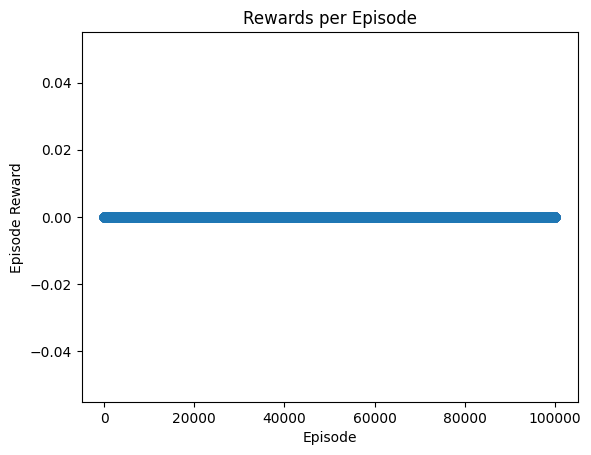

In [10]:
Default.plot_rewards()

Plot of the resulting Q-table.

Print of the optimal action for each state, according to the obtained Q-table values. All we need to do is to get the action with the maximum value.

In [11]:
Default.print_optimal()

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


Visualize, state by state, the outcome of following a greedy policy. For that, you just need to choose the best action in each state.

In [14]:
Default.greedy_policy()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 1: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 2: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 3: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 4: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 5: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 6: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 7: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 8: Chose action 0 - Non-diagonal Move
  (Left)

- **Custom:**

In [33]:
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False, render_mode="ansi")
env = CustomRewardWrapper(env)
#env = CustomActionWrapper(env)
env.reset()
print(env.render())


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [34]:
Custom = QLearn(env,total_episodes,max_steps,learning_rate,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,8)
Custom.q_learning()

Plot of the cummulative reward obtained throughout the episodes.


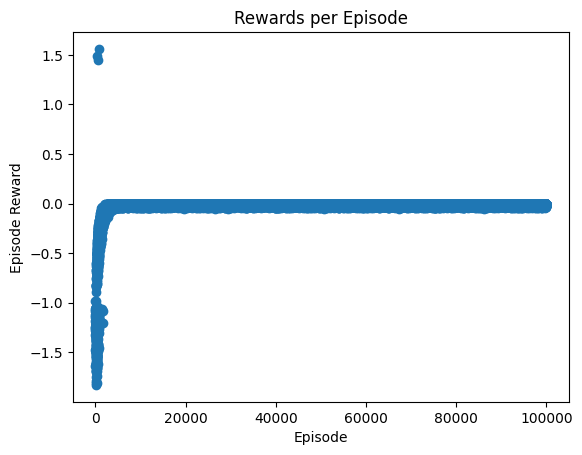

In [35]:
Custom.plot_rewards()

Print of the optimal action for each state, according to the obtained Q-table values. All we need to do is to get the action with the maximum value.

In [36]:
Custom.print_optimal()

[[0 0 0 0 0 0 3 1]
 [3 0 0 0 0 2 2 1]
 [3 0 0 0 1 2 1 1]
 [3 0 0 2 1 0 1 1]
 [3 0 3 0 2 1 2 1]
 [3 0 0 2 0 1 0 1]
 [1 0 2 3 0 1 0 1]
 [2 2 1 0 0 0 0 0]]


Visualize, state by state, the outcome of following a greedy policy. For that, you just need to choose the best action in each state.

In [37]:
Custom.greedy_policy()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 1: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 2: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 3: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 4: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 5: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 6: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 7: Chose action 0 - Non-diagonal Move
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step 8: Chose action 0 - Non-diagonal Move
  (Left)

As it took a long time to run with 2M timesteps and still couldn't find a solution, we decided to just use 4x4 in our work.

## Tuning Hyperparameters PPO

- After testing, we decided to lower **gamma** and increase **learning_rate** a little bit to see if it has impact in out model performance (decided to train for 300k episodes because we did not notice a big difference when we trained with 1M on the default):

### <font color='blue'>**BLUE**</font> is *custom* and <font color='green'>**GREEN**</font> is *default*

- Before tuning:

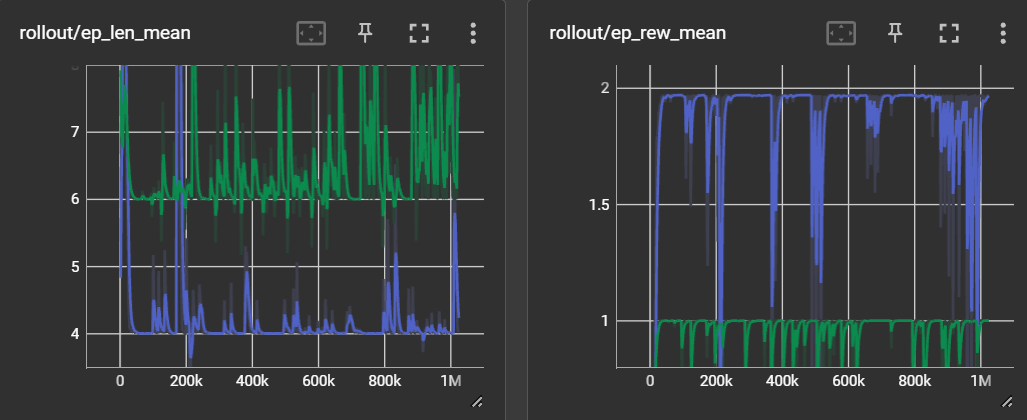

- After tuning:

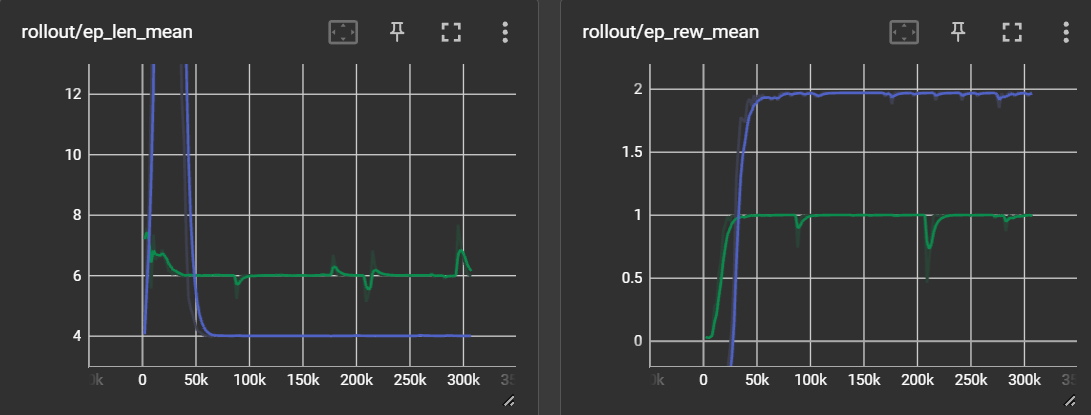

We can see that the learning process is way more stable after tuning the hyperparameters.

- Now we will see how many times each model gets the optimal solution for **1000 episodes**:

In [13]:
def testing_default(models_dir):
    env = gym.make('FrozenLake-v1',is_slippery=False, render_mode="rgb_array")
    env.reset()
    model_path = f"{models_dir}/990000.zip" #290000.zip for tuned
    model = PPO.load(model_path, env=env)
    
    episodes = 1000
    error = 0
    
    for ep in range(episodes):
        moves = []
        reward_total = 0
        obs,info = env.reset()
        done = False
        while not done:
            action, _states = model.predict(obs)
            moves.append(int(action))
            obs, rewards, done, trunc, info = env.step(int(action))
    
            reward_total += rewards
            env.render()
 
        if len(moves) != 6 or reward_total != 1:
            error += 1
             
    print(f"Not the optimal solution: {error} out of {episodes} episodes")

In [14]:
testing_default("models/PPO_Default4x4")

Not the optimal solution: 242 out of 1000 episodes


In [12]:
testing_default("models/Default_tuned")

Not the optimal solution: 9 out of 1000 episodes


In [30]:
def testing_custom(models_dir):
    env = gym.make('FrozenLake-v1',is_slippery=False, render_mode="rgb_array")
    env.reset()
    model_path = f"{models_dir}/990000.zip" #290000.zip for tuned
    env = CustomRewardWrapper(env)
    env = CustomActionWrapper(env)
    model = PPO.load(model_path, env=env)
    
    episodes = 1000
    error = 0
    
    for ep in range(episodes):
        moves = []
        reward_total = 0
        obs,info = env.reset()
        done = False
        while not done:
            action, _states = model.predict(obs)
            moves.append(int(action))
            obs, rewards, done, trunc, info = env.step(int(action))
    
            reward_total += rewards
            env.render()
 
        if len(moves) != 4 or reward_total != 1.97:
            error += 1
             
    print(f"Not the optimal solution: {error} out of {episodes} episodes")

In [33]:
testing_custom("models/PPO_Custom4x4")

Not the optimal solution: 3 out of 1000 episodes


In [29]:
testing_custom("models/Custom_tuned")

Not the optimal solution: 5 out of 1000 episodes


- In conclusion, the hyperparameter tuning improved drastically the performance of the default environment and basically remained the same for the custom.